In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [2]:
from ccai9012 import nn_utils, viz_utils

## Step 1: Load the Fashion MNIST dataset from Hugging Face

In [3]:
# Load the dataset directly from Hugging Face
from datasets import load_dataset
dataset = load_dataset("fashion_mnist")

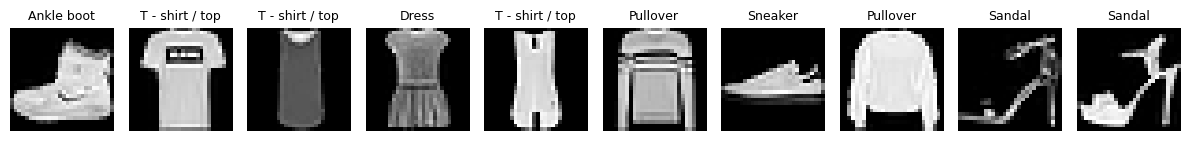

In [5]:
# Get the label names from the dataset
class_names = dataset['train'].features['label'].names

def show_samples(dataset, num_images=10):
    plt.figure(figsize=(12, 2))
    for i in range(num_images):
        image = dataset['train'][i]['image']
        label = dataset['train'][i]['label']
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(class_names[label], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 10 sample images
show_samples(dataset)

## Step 2: Processing dataset for model training

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [7]:
# Wrap the Hugging Face dataset as a PyTorch Dataset
class FashionDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
# Prepare training, validation, and test sets

# Split training into train/validation sets
full_train_dataset = FashionDataset(dataset['train'], transform=transform)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Prepare test set
test_dataset = FashionDataset(dataset['test'], transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Step 3: Define a simple CNN model

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (1, 28, 28) -> (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),# -> (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # -> (64, 7, 7)
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)                          # 10 output classes
        )

    def forward(self, x):
        return self.model(x)

## Step 4: Model training

In [11]:
# Set up training configuration
model = SimpleCNN()
num_epochs = 10

# CrossEntropyLoss applies softmax + loss in one step
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
train_losses, val_losses = nn_utils.train_model(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    criterion, 
    num_epochs
)

Epoch [1/10] - Train Loss: 0.4633, Val Loss: 0.3282
Epoch [2/10] - Train Loss: 0.2996, Val Loss: 0.2797
Epoch [3/10] - Train Loss: 0.2526, Val Loss: 0.2452
Epoch [4/10] - Train Loss: 0.2150, Val Loss: 0.2251
Epoch [5/10] - Train Loss: 0.1870, Val Loss: 0.2247
Epoch [6/10] - Train Loss: 0.1677, Val Loss: 0.2356
Epoch [7/10] - Train Loss: 0.1465, Val Loss: 0.2245
Epoch [8/10] - Train Loss: 0.1251, Val Loss: 0.2285
Epoch [9/10] - Train Loss: 0.1090, Val Loss: 0.2332
Epoch [10/10] - Train Loss: 0.0925, Val Loss: 0.2435


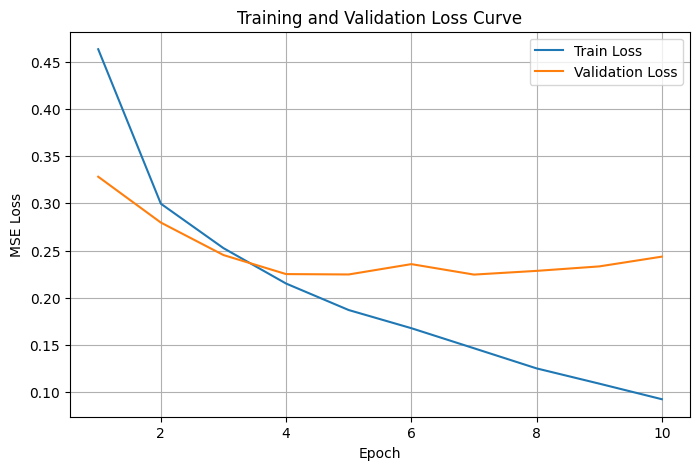

In [13]:
# Plot Training and Validation Loss
viz_utils.plot_loss_curve(train_losses, val_losses)

## Evaluate the model on the test set

Accuracy: 92.01%

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.90      0.87      0.88      1000
           3       0.92      0.93      0.92      1000
           4       0.87      0.89      0.88      1000
           5       0.98      0.99      0.98      1000
           6       0.79      0.74      0.77      1000
           7       0.98      0.95      0.96      1000
           8       0.98      0.99      0.98      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



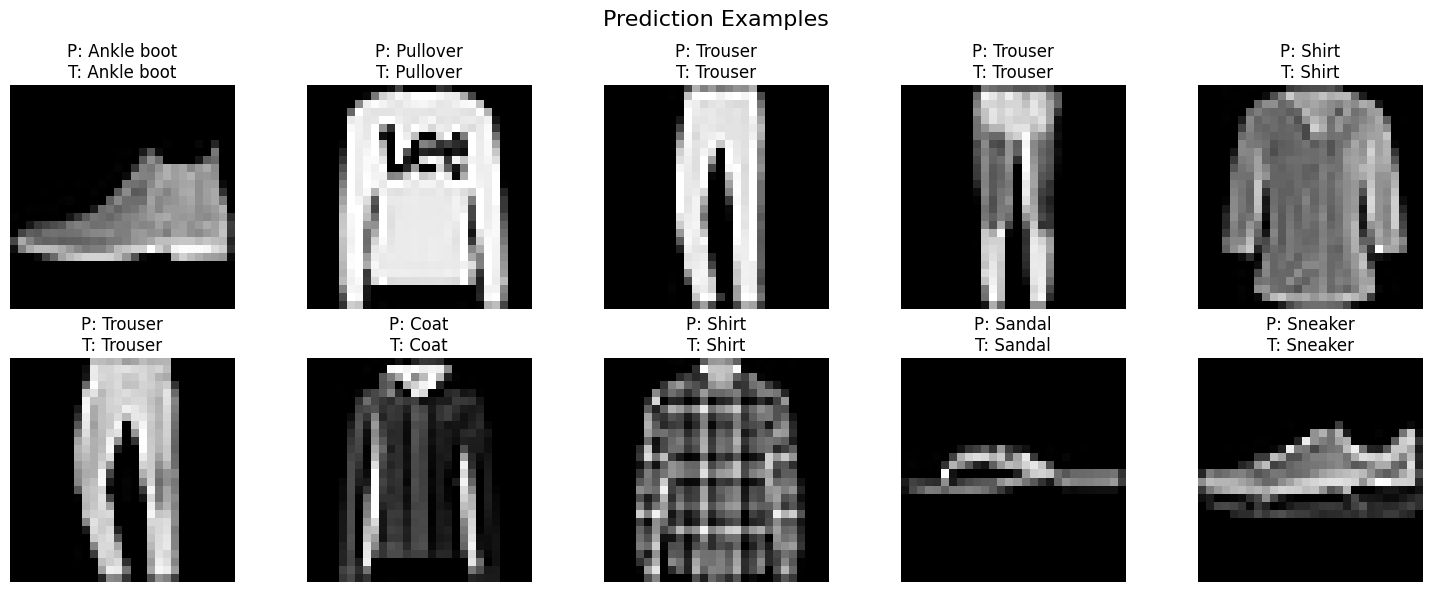

In [14]:
class_names = dataset['train'].features['label'].names

reuslts = nn_utils.evaluate_classification_model(
    model,
    test_loader,
    show_examples=True,
    class_names=class_names,
    num_examples=10,
    example_plot_title="Prediction Examples",
)